# #1 初心者向け講座

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

## データの読み込み

In [4]:
INPUT_DIR = "/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset"
OUTPUT_DIR = "/content/drive/MyDrive/atmaCup/#13/outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
for p in glob(os.path.join(INPUT_DIR, "*")):
    print(p)

/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/session.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/product_master.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/price.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/cart_log.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/test_session.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/coupon_target_jan.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/coupon.csv
/content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/atmaCup13_sample_submission.csv


In [6]:
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + ".csv")
    print(f"Load: {path}")
    return pd.read_csv(path, **kwrgs)

In [7]:
# カートログ
log_df = read_csv("cart_log", parse_dates=["created_at__hour"], dtype={ "JAN": str })

# セッション情報
session_df = read_csv("session", parse_dates=["start_at__date"])
test_session_df = read_csv("test_session")

# クーポン情報
coupon_df = read_csv("coupon")
coupon_target_jan_df = read_csv("coupon_target_jan", dtype={ "JAN": str })

# 商品情報
price_df = read_csv("price", dtype={ "JAN": str })
product_master_df = read_csv("product_master", dtype={ "JAN": str })

Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/cart_log.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  


Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/session.csv
Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/test_session.csv
Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/coupon.csv
Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/coupon_target_jan.csv
Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/price.csv
Load: /content/drive/MyDrive/atmaCup/#13/atmaCup13_dataset/product_master.csv


In [8]:
def get_target_jan_list():
    """予測対象のカテゴリ(チーズ)のJANコードを取得する"""
    idx = product_master_df["category"] == "チーズ"
    return product_master_df[idx]["JAN"].unique()

# 予測対象の JAN は変わらない (定数) ですので、それがわかるよう CAPITAL で定義します。
TARGET_JANS = get_target_jan_list()

print(f"チーズのJANコード #{len(TARGET_JANS)}")

チーズのJANコード #1696


In [9]:
idx_after_180 = log_df["duration"] >= 180
idx_has_jan = log_df["JAN"].isin(TARGET_JANS)

_df = log_df[idx_after_180 & idx_has_jan].reset_index(drop=True)

In [10]:
sum_of_item = _df.groupby(["session_id", "JAN"])["n_items"].sum().reset_index()
sum_of_item.head()

,session_id,JAN,n_items
0,0008030d60a542f1b8a1f6d01bc97d9c49147bf8de0e61...,49839807,3
1,000b59b199378f06d7c25f2d5dfdcf8bea2452400d277a...,4961681006292,1
2,0020d571d43bf4984396b01b4a800f62deab2c8385cb05...,4961681002263,1
3,002157a232e800522d85e4a19247534dfe3e4963bada52...,4903308004670,2
4,003357795a4a31f32c25a71da4583dabafe7776ed5db24...,4903308035582,1


In [11]:
# 新しく購入があった session - JAN の組
idx = sum_of_item["n_items"] > 0

# 購入するゼロ or マイナスのもの
sum_of_item[~idx]

,session_id,JAN,n_items
58,01b12b339ca77ab1049055d27fe6cf94453281d1396557...,4903308004694,0
59,01b12b339ca77ab1049055d27fe6cf94453281d1396557...,4903308039535,0
186,0666d351c8dc1a39897748132d9bf6a10c631459012a77...,4902732803439,0
205,0711f3a8e4e69f9e4ebaf0cf5ff5f1ff6ffa7b2cba82a4...,3073781162257,0
238,07f4458b9c6460798d6c2a41059ea6110c2739f4c3e1cb...,4903050502950,0
...,...,...,...
8137,fb51a2ee49894b7ccb8c1a7582aade99fbdfaa0c47cb5b...,49839807,0
8196,fd0f357c177ccfb451ba3f899abd6185f42edb9fc70218...,4903308032352,0
8217,fdacd310095a1192f5ddd1c1b1c865a6f27023d79dfa83...,3073781162257,0
8264,fe9b2053e9984f12bd71abff29900291883288c7337c1a...,4522646853896,0


In [12]:
# 購入するゼロ or マイナスのセッションを試しに見てみるのも良いでしょう
def filter_by_sessions(input_df: pd.DataFrame, sessions: list):
    idx = input_df["session_id"].isin(set(sessions))
    return input_df[idx].reset_index(drop=True)

filter_by_sessions(log_df, sessions=sum_of_item[~idx]["session_id"]).to_csv(os.path.join(OUTPUT_DIR, "チーズを購入しているが購入数合計がゼロのセッション.csv"), index=False)

In [13]:
# 新しく購入があった index に絞って, session の集合を計算します。これが「チーズを新しく買った」セッションです。
buy_sessions = sum_of_item[idx]["session_id"].unique()

# これも試しに見てみるのが良いでしょう
# 数が多いと見難いので 100 こだけ。
filter_by_sessions(log_df, sessions=buy_sessions[:100]).to_csv(os.path.join(OUTPUT_DIR, "チーズを購入しているセッション.csv"), index=False)

In [14]:
idx_tr = session_df["start_at__date"] <= "2022-01-06"
train_session_df = session_df[idx_tr].reset_index(drop=True)[["session_id"]]

train_session_df["y"] = train_session_df["session_id"].isin(buy_sessions).astype(int)

In [15]:
def calculate_buy_sessions(input_df: pd.DataFrame) -> set:
    """
    180秒後にチーズカテゴリの商品を新規に購入したセッションを取得します.
    
    Args:
        input_df: 
            cart_log.csv のデータ.

    Returns:
        購入があったセッション集合
    """

    idx_after_180 = input_df["duration"] >= 180
    idx_has_cheese = input_df["JAN"].isin(TARGET_JANS)

    # 180秒後かつチーズの商品追加・削除に関係するログにしぼりこんで, 
    _df = input_df[idx_after_180 & idx_has_cheese].reset_index(drop=True)

    # session ごとに JAN (商品) をいくつ買ったかを計算して,
    sum_of_item = _df.groupby(["session_id", "JAN"])["n_items"].sum().reset_index()

    # 新しく購入があった session - JAN の index に絞り
    idx = sum_of_item["n_items"] > 0
    sum_of_item = sum_of_item[idx]

    # session の集合を計算します。これが「チーズを新しく買った」セッションです。
    buy_sessions = sum_of_item["session_id"].unique()
    return set(buy_sessions)

In [16]:
sessions = calculate_buy_sessions(log_df)

In [17]:
len(sessions) == len(set(buy_sessions))

True

In [18]:
log_df[log_df["session_id"].isin(test_session_df["session_id"])]["duration"].agg(["min", "max"])

min      0
max    179
Name: duration, dtype: int64

### Cross Validation

In [19]:
# 何回も `session_id` と書くのがたいへんなので変数として定義しました
# こうすると tab を押すとサジェストが効くので楽です
SESSION_ID = "session_id"

def merge_by_session(left: pd.DataFrame, right: pd.DataFrame, drop_key=True) -> pd.DataFrame:
    out_df = pd.merge(left[SESSION_ID], right, on=SESSION_ID, how="left")
    
    if drop_key:
        out_df = out_df.drop(columns=[SESSION_ID])
    return out_df

In [20]:
def train_session_day(input_df: pd.DataFrame):
    date_series = session_df["start_at__date"]
    _df = pd.DataFrame({
        SESSION_ID: session_df[SESSION_ID],
        "start_at__date": date_series,
    })
    
    return merge_by_session(input_df, _df)

In [21]:
groups = train_session_day(train_session_df)

In [22]:
!pip uninstall scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 27.6 MB 40.4 MB/s 


In [23]:
from sklearn.model_selection import StratifiedGroupKFold

fold = StratifiedGroupKFold(n_splits=5, shuffle=False)
cv = fold.split(train_session_df["y"].values, train_session_df["y"].values, groups)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく

### 数値に紐づく情報

In [24]:
# 本当は int にしたいのですが python(numpy) では Nan が float 型で定義されているため flaot としています
session_df["distance_to_the_store"] = session_df["distance_to_the_store"].replace("不明", None).astype(float)

In [25]:
def create_distance_to_the_store_feature(input_df: pd.DataFrame) -> pd.DataFrame:
    return merge_by_session(left=input_df, right=session_df[[SESSION_ID, "distance_to_the_store"]])

In [26]:
create_distance_to_the_store_feature(train_session_df)

,distance_to_the_store
0,2.0
1,4.0
2,18.0
3,2.0
4,2.0
...,...
83333,1.0
83334,8.0
83335,1.0
83336,9.0


In [27]:
def create_start_at_date_feature(input_df: pd.DataFrame):
    date_series = session_df["start_at__date"]
    _df = pd.DataFrame({
        SESSION_ID: session_df[SESSION_ID],
        "dayofweek": date_series.dt.dayofweek,
    })
    
    return merge_by_session(input_df, _df)

### カテゴリ変数の情報

#### OneHotEncoding

In [28]:
def create_one_hot_encoding_feature(input_df: pd.DataFrame, target_column: str) -> pd.DataFrame:
    _series = merge_by_session(input_df, session_df)[target_column]
    uniques = session_df[target_column].dropna().unique()

    cat_series = pd.Categorical(_series, categories=uniques)
    out_df = pd.get_dummies(cat_series)
    out_df.columns = out_df.columns.tolist()
    return out_df

### パーセンタイルを用いたtarget encoding

In [29]:
N = len(train_session_df)
N

83338

In [30]:
p = train_session_df["y"].sum() / len(train_session_df)
p

0.07865559528666395

Bin(N, p)の二項分布として考えられる？

In [31]:
use_df = pd.merge(train_session_df, session_df[["session_id", "user_id"]], on="session_id", how="left")

In [32]:
use_df.groupby("user_id")["y"].sum().max()

14

In [33]:
use_df.groupby("user_id").size().max()

103

チーズを購入してる回数が少ないので計算量も大丈夫そう！

In [34]:
# p^nと(1-p)^nを先に求めておく

POWER_p = [1] * 201
for i in range(200):
    POWER_p[i + 1] *= POWER_p[i] * p
POWER_1_p = [1] * 201
for i in range(200):
    POWER_1_p[i + 1] *= POWER_1_p[i] * (1 - p)

In [35]:
# 全体の分布がBin(N, p)に従うときにn回スーパーに行ったうちk回チーズを購入した人が下位何パーセントだったのかを求める

def calc_percentile(x):
    n, k = x[0], x["y"]
    ret = 0
    for i in range(k + 1):
        tmp = 1
        for x in range(n, n - i, -1):
            tmp *= x
        for x in range(i):
            tmp /= x + 1
        tmp *= POWER_p[i]
        tmp *= POWER_1_p[n - i]
        if i == k:
            tmp /= 2
        ret += tmp
    return ret

In [36]:
pd.concat([use_df.groupby("user_id")["y"].sum(), use_df.groupby("user_id").size()], axis = 1).apply(calc_percentile, axis = 1)

user_id
00013ab2b36e1084ef754b36bdda0b0b99f09c52f9b90ea57c65f5f18dc74cc0    0.424438
00073acd012cd8296299265d2e61e958a9bc8fc360d2b1b17118c4a7879e6e78    0.331956
001fbef84528c709e5e899835516a5e045069bdf0e048aaf5ca8e255fe959299    0.305845
002d8d3d0a2d530e70abc27b6c36b776658102597040e3a2152a8eb72ae90f8b    0.460672
003119bec7a4021ee4474a832c4e6fcd0186d13a6c9445879c16b26a05bd42e7    0.305845
                                                                      ...   
ffdc2476f6f845434a908162785c5514fa836e0b1ad0fe7846bc4bce0841cfb9    0.731973
ffe2610647242a9795f1a179937f52bb26787dedbd326675cb784c868f73f8fa    0.360295
ffe6ca51c9074134d9484fee89db755dbfa6b94f1eed53dd288c290835086b1d    0.460672
ffea41c6dc0c7611f67403086cda2d126299b16f8b01a3f7613720517e26e0ca    0.220389
fffe3513c44c5fcbbbec5772279341cac64de5bac11b762720ec8959bd61bbd7    0.391053
Length: 12804, dtype: float64

In [37]:
def create_percentile_target_encoding_by_userid_feature(input_df: pd.DataFrame) -> pd.DataFrame:
    if input_df.shape[0] == 25823:
        use_df = pd.merge(train_session_df, session_df[["session_id", "user_id"]], on="session_id", how="left")
        target_encoding_dict = dict(pd.concat([use_df.groupby("user_id")["y"].sum(), use_df.groupby("user_id").size()], axis = 1).apply(calc_percentile, axis = 1))
        df_ = pd.merge(input_df, session_df[["session_id", "user_id"]], on="session_id", how="left")
        df_.loc[:, "target_encoding_by_userid"] = df_.loc[:, "user_id"].map(target_encoding_dict)
        df_["target_encoding_by_userid"] = df_["target_encoding_by_userid"].fillna(np.nan)
        return pd.DataFrame(df_["target_encoding_by_userid"])

    df_ = pd.merge(input_df, session_df[["session_id", "user_id"]], on="session_id", how="left")
    for train_idxs, test_idxs in cv:
        target_encoding_dict = dict(pd.concat([df_.loc[train_idxs,:].groupby("user_id")["y"].sum(), df_.loc[train_idxs,:].groupby("user_id").size()], axis = 1).apply(calc_percentile, axis = 1))
        df_.loc[test_idxs, "target_encoding_by_userid"] = df_.loc[test_idxs, "user_id"].map(target_encoding_dict) 
    df_["target_encoding_by_userid"].fillna(np.nan)
    return df_["target_encoding_by_userid"]

### すべての特徴量を合体させる

上記で定義した特徴量をすべて合わせたデータフレームを作成する関数を用意しましょう。いま数値とカテゴリ(one-hot-encoding) の2つの関数を作りましたので、これらを複数のカラムで使うような関数に仕立てます。

In [38]:
def create_session_one_hot_features(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
        "sex",
        "age"
    ]
    
    out_df = pd.DataFrame()
    
    for c in use_columns:
        _df = create_one_hot_encoding_feature(input_df, target_column=c).add_prefix(f"{c}=")
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [39]:
create_session_one_hot_features(train_session_df)

,sex=女性,sex=男性,sex=不明,age=60~64,age=55~59,age=35~39,age=30~34,age=25~29,age=50~54,age=70~74,age=65~69,age=45~49,age=不明,age=15~19,age=75~79,age=40~44,age=20~24,age=80~84,age=85~89,age=10~14,age=100~,age=0~4,age=90~94,age=5~9,age=95~99
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83333,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83334,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83335,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
83336,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 見えているログの情報の活用

今回は予測のとき 180 秒までの部分のログは見ることができます。このログの情報を特徴量にしてみましょう。

In [40]:
# 何回も使うので, 見えるログを `visible_log_df` として定義しておく
idx_visible = log_df["duration"] < 180
visible_log_df = log_df[idx_visible].reset_index(drop=True)

このログをつかって、セッションごとの特徴になりそうなものを考えてみましょう!

たとえば、最初すごく商品を買っている人かどうかがチーズ購入に影響が大きいかも?と思ったら「セッションごとに購入個数の合計」などを計算してみたくなりますね。

In [41]:
# セッションごと (groupby) に, 個数 n_items を, 合計 sum する
visible_log_df.groupby("session_id")["n_items"].sum()

session_id
00003ee1b7f34620ae81dba533c6d5a544513004fe5688b2a88560e071799c0e    0
00011e97d485ffb7f78662972da6032d4103b1628d541f8f0b916fc011a592e6    6
000280d2156d179a597167b269a69e5af556725eeaabae21226d755f73bf0bd9    3
0002a4a49d2230456ce57f9709b7c97e1ee324906f4ed8993b579d0ef0ed6135    0
000383cb2018d041d4976a0e26d2dc0b73918abd5a30c94179441f321aa598c0    3
                                                                   ..
fffc962b9f45b0059808e4911a71a88e278afd156116ef8f0e2d07983b605718    9
fffd70401bffc2d2b7c5980bce4d373d693f6ffa26f0bbe03837bcc6ddd46c25    1
fffd9fafd8f535a35e4a5d526298c9ae4bf102d4329a6d8434815b6e0cad272d    3
ffff3b41d0dadb1efd1d413aa9e8bbe66349455576c4375b5a9ccce3c4748790    1
ffffdde1709024552278324dcbbeb8bc0e2bb39e462eb051ad14457da1c5a257    3
Name: n_items, Length: 109130, dtype: int64

すごーくシンプルにするなら「180秒まででどれだけせかせか動いているか (イベント件数がいくつあるか)」 もその一つですね。

In [42]:
# セッションごとにイベントが何件あるか
visible_log_df.groupby("session_id").size()

session_id
00003ee1b7f34620ae81dba533c6d5a544513004fe5688b2a88560e071799c0e    1
00011e97d485ffb7f78662972da6032d4103b1628d541f8f0b916fc011a592e6    7
000280d2156d179a597167b269a69e5af556725eeaabae21226d755f73bf0bd9    6
0002a4a49d2230456ce57f9709b7c97e1ee324906f4ed8993b579d0ef0ed6135    1
000383cb2018d041d4976a0e26d2dc0b73918abd5a30c94179441f321aa598c0    4
                                                                   ..
fffc962b9f45b0059808e4911a71a88e278afd156116ef8f0e2d07983b605718    8
fffd70401bffc2d2b7c5980bce4d373d693f6ffa26f0bbe03837bcc6ddd46c25    2
fffd9fafd8f535a35e4a5d526298c9ae4bf102d4329a6d8434815b6e0cad272d    4
ffff3b41d0dadb1efd1d413aa9e8bbe66349455576c4375b5a9ccce3c4748790    2
ffffdde1709024552278324dcbbeb8bc0e2bb39e462eb051ad14457da1c5a257    4
Length: 109130, dtype: int64

別の人は「いろんな商品を買うような人は目移りするからチーズも買うかも?」と考えるかも知れません。これを表す情報の一つは「セッションごとの商品のユニーク数」ですね。

In [43]:
visible_log_df.groupby("session_id")["JAN"].nunique()

session_id
00003ee1b7f34620ae81dba533c6d5a544513004fe5688b2a88560e071799c0e    0
00011e97d485ffb7f78662972da6032d4103b1628d541f8f0b916fc011a592e6    4
000280d2156d179a597167b269a69e5af556725eeaabae21226d755f73bf0bd9    3
0002a4a49d2230456ce57f9709b7c97e1ee324906f4ed8993b579d0ef0ed6135    0
000383cb2018d041d4976a0e26d2dc0b73918abd5a30c94179441f321aa598c0    2
                                                                   ..
fffc962b9f45b0059808e4911a71a88e278afd156116ef8f0e2d07983b605718    3
fffd70401bffc2d2b7c5980bce4d373d693f6ffa26f0bbe03837bcc6ddd46c25    1
fffd9fafd8f535a35e4a5d526298c9ae4bf102d4329a6d8434815b6e0cad272d    3
ffff3b41d0dadb1efd1d413aa9e8bbe66349455576c4375b5a9ccce3c4748790    1
ffffdde1709024552278324dcbbeb8bc0e2bb39e462eb051ad14457da1c5a257    3
Name: JAN, Length: 109130, dtype: int64

#### NOTE:

* 他にも色々と考えることが出来るでしょう。データを見て色々なことを想像して、面白い特徴量を作ってみましょう!

----

では上記で作ったセッションごとの特徴を作成する関数を作ります。集計 (groupby) はすべて `session_id` でされているので `pd.concat` で横方向にくっつけることができます。

In [44]:
agg_df = pd.concat([
    # セッションごとにイベントが何件あるか
    visible_log_df.groupby("session_id").size().rename("log_size"),
    
    visible_log_df.groupby("session_id")["n_items"].sum().rename("n_items_sum"),
    
    visible_log_df.groupby("session_id")["JAN"].nunique().rename("jan_uniques"),
], axis=1)

agg_df

,log_size,n_items_sum,jan_uniques
session_id,,,
00003ee1b7f34620ae81dba533c6d5a544513004fe5688b2a88560e071799c0e,1,0,0
00011e97d485ffb7f78662972da6032d4103b1628d541f8f0b916fc011a592e6,7,6,4
000280d2156d179a597167b269a69e5af556725eeaabae21226d755f73bf0bd9,6,3,3
0002a4a49d2230456ce57f9709b7c97e1ee324906f4ed8993b579d0ef0ed6135,1,0,0
000383cb2018d041d4976a0e26d2dc0b73918abd5a30c94179441f321aa598c0,4,3,2
...,...,...,...
fffc962b9f45b0059808e4911a71a88e278afd156116ef8f0e2d07983b605718,8,9,3
fffd70401bffc2d2b7c5980bce4d373d693f6ffa26f0bbe03837bcc6ddd46c25,2,1,1
fffd9fafd8f535a35e4a5d526298c9ae4bf102d4329a6d8434815b6e0cad272d,4,3,3


あとはこれを数値・カテゴリのときと同じように `session_id` で紐付けすればOKです。

In [45]:
def create_visible_log_feature(input_df):
    agg_df = pd.concat([
        # セッションごとにイベントが何件あるか
        visible_log_df.groupby("session_id").size().rename("log_size"),

        visible_log_df.groupby("session_id")["n_items"].sum().rename("n_items_sum"),

        visible_log_df.groupby("session_id")["JAN"].nunique().rename("jan_uniques"),
    ], axis=1)

    return merge_by_session(input_df, right=agg_df).add_prefix("visible_log__").fillna(0)

### 全部入りの特徴量を作る

In [46]:
def build_features(input_df):
    feature_functions = [
        create_distance_to_the_store_feature,
        create_start_at_date_feature,
        create_session_one_hot_features,
        create_visible_log_feature,
        # もっと関数を作ったらここに入れていく!
        create_percentile_target_encoding_by_userid_feature
    ]
    
    print("start build featrures.")
    out_df = pd.DataFrame()

    for func in feature_functions:
        with Timer(prefix=f"\t -run: {func.__name__}..."):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [47]:
train_featuer_df = build_features(train_session_df)
test_feature_df = build_features(test_session_df)

start build featrures.
	 -run: create_distance_to_the_store_feature... 0.081[s]
	 -run: create_start_at_date_feature... 0.092[s]
	 -run: create_session_one_hot_features... 0.289[s]
	 -run: create_visible_log_feature... 0.766[s]
	 -run: create_percentile_target_encoding_by_userid_feature... 3.414[s]
start build featrures.
	 -run: create_distance_to_the_store_feature... 0.158[s]
	 -run: create_start_at_date_feature... 0.165[s]
	 -run: create_session_one_hot_features... 0.335[s]
	 -run: create_visible_log_feature... 1.285[s]
	 -run: create_percentile_target_encoding_by_userid_feature... 1.183[s]


In [48]:
idx = pd.merge(train_session_df, session_df[["session_id", "user_id"]], on = "session_id", how = "left")["user_id"].isin(pd.merge(test_session_df, session_df[["session_id", "user_id"]], on = "session_id", how = "left")["user_id"].unique())

In [49]:
train_featuer_df.loc[~idx, "target_encoding_by_userid"] = np.nan

In [50]:
X, y = train_featuer_df.values, train_session_df["y"].values

In [51]:
X.shape, y.shape

((83338, 31), (83338,))

## 学習を行なう

特徴量を作成できたので次にモデルの学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation とは

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### なんで Cross Validation するの?

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

> 仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

一番ナイーブな戦略は Random と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。

あとは「各分割で特定のグループが重ならないようにする」Group もよく使われます。

その他にも時系列で区切る TimeSeriesSplit という方法もあります。

### どの分割方法がいいの?

いろいろと分割方法があると説明しましたが、どの分割方法が一番良いでしょうか。

まず良い分割とはなにかを考えてみましょう。良い分割とは今のモデルがテストデータでどのぐらいの性能を出すかを、検証データで確認できる分割です。

これはすなわち、分割された学習/検証用データが、全体の学習/テストデータとの対応関係と一致していることといえるでしょう。
したがって分割を決める際には学習データとテストデータの関係性をしらべ、それと同じ分割を採用する必要があります。

### LightGBM による CrossValidation を用いた学習

今回は使う機械学習モデルとして lightGBM を使います。lightGBM は以下のような良い性質があります。

* GBDT と呼ばれるアルゴリズムの一種でテーブルデータで性能が高いことが知られている
* 欠損値が存在している場合にも自然に取り扱えるため特に処理が必要ない
* 特徴重要度をさっと出すことができる
* CPU 環境でも高速に学習・推論が行える

ほかにも理由はありますが [u++ さんの 「初手LightGBM」をする7つの理由](https://upura.hatenablog.com/entry/2019/10/29/184617) などが参考になります。

In [52]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={} ".format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        # 今回の指標の macro f1 で計算する
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = roc_auc_score(y, oof_pred)
    print(f"{score:.4f}")
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、そこまでセンシティブではありません。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできますので、重要な変数に関してはその意味についてざっと目を通しておくことをおすすめします。

以下参考文献です。


* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語です。
* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。日本語です。

In [53]:
goto_params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "binary", 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .1,

    # L2 Reguralization
    "reg_lambda": .1,
    # こちらは L1 
    "reg_alpha": 0,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    "max_depth": 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    "colsample_bytree": .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    "min_child_samples": 10,

    # bagging の頻度と割合
    "subsample_freq": 3,
    "subsample": .9,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 71,
}

In [54]:
oof, models = fit_lgbm(X=X, y=y, cv=cv, params=goto_params)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_logloss: 0.255836
[100]	valid_0's binary_logloss: 0.255618
[150]	valid_0's binary_logloss: 0.255664
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.255583
fit fold=0  18.193[s]
 - fold1 - 0.6714
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_logloss: 0.255495
[100]	valid_0's binary_logloss: 0.256009
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.255447
fit fold=1  1.368[s]
 - fold2 - 0.6569
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_logloss: 0.288803
[100]	valid_0's binary_logloss: 0.289157
[150]	valid_0's binary_logloss: 0.289671
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.288803
fit fold=2  1.424[s]
 - fold3 - 0.6667
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_logloss: 0.255437
[100]	valid_0's binary_logloss: 0.256038

### 学習済みモデルを理解する

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。また何故この予測が出てくるかの解釈をする上でも有用です。

note: 今回利用した lightGBM は内部的に特徴の値での IF をたくさん重ねているモデルなので、どの特徴で IF を作っているか + それによって予測性能がどのぐらい改善するかを利用して特徴量ごとの貢献度 (特徴重要度) を算出することができます。

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22899 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24615 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30007 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19981 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22899 missing from current font.
  font.set_

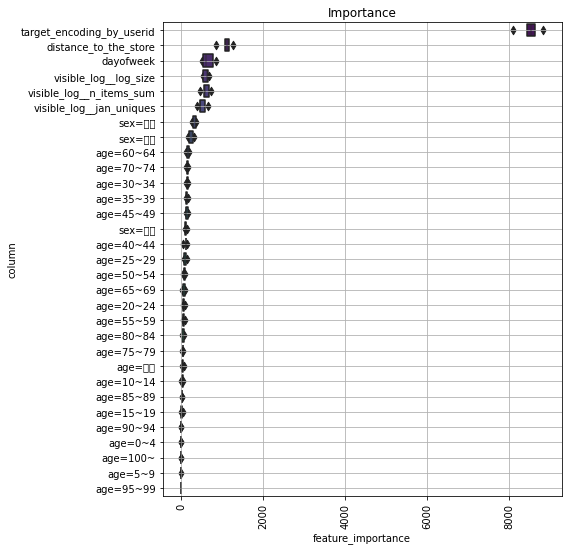

In [55]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_featuer_df)

feature_importance は値が大きいほど有効な分割であることを意味します。これを解釈すると…

* 店舗までの距離情報がもっとも有効です。
    * ユーザの属性情報が大事そうです。
    * ただ属性の中でも大事なものとそうでないもの (年齢・性別 << 距離) がありそうです。
* 二番目に大事なのは曜日でした。
* 当日のログ情報はそれなりに有効です。直感にあっていてホッとしますね。

In [56]:
models

[LGBMClassifier(colsample_bytree=0.5, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_bytree=0.5, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_bytree=0.5, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_bytree=0.5, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_la

In [57]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (k, N_test, n_classes).
pred_prob = np.array([model.predict_proba(test_feature_df.values) for model in models])
print(f"1. shape: {pred_prob.shape}")

# k 個のモデルの平均を計算
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる 
print(f"2. shape: {pred_prob.shape}")

# ほしいのは y=1 の確率なので全要素の 1 次元目を取ってくる
pred_prob = pred_prob[:, 1]
print(f"3. shape: {pred_prob.shape}")

1. shape: (5, 25823, 2)
2. shape: (25823, 2)
3. shape: (25823,)


### テスト時の予測結果の傾向を見ておく

どういったラベルが予測されているか? などの傾向を知っておきましょう。また学習時とテスト時で出力の乖離が無いか、を見ることも大事です。乖離が大きい場合には、入力する値自体が大きく異なっているなどで性能悪化が起こっている可能性があります。

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


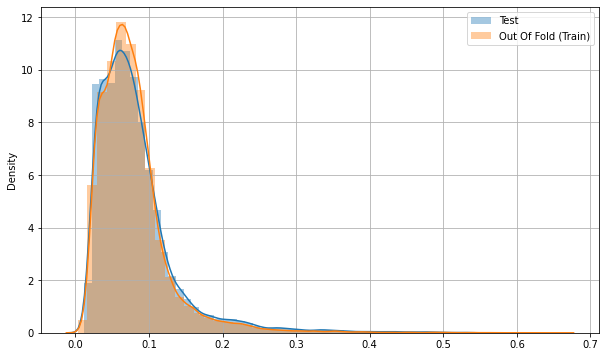

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(pred_prob, ax=ax, label="Test")
sns.distplot(oof, ax=ax, label="Out Of Fold (Train)")
ax.legend()
ax.grid()

#### NOTE: テストでの乖離が大きい・はどういうことか

テストの予測値の乖離が大きい場合の原因はいくつか考えられますが「テスト時に使えない情報を特徴量としてつかっていないか?」を最も警戒してください。

テスト時に使えない特徴 A を利用してモデルを作っていると、学習時に A をみるようなモデルが出来る可能性があり、テスト時にそれを参照できないことで予測が上手く行かない場合があります。

もっとも極端なのは A が予測ラベルそのものである場合です。学習時は予測ラベルを参照できますから、それこそ精度100%で予測できるようなモデルができますが、テスト時には当然予測ラベルはわかりませんので、精度は大きく悪化するでしょう。このように予測ラベルの情報が学習時の特徴量に染み出してしまった結果学習が上手く行かないことをリークとよびます。

テストでの乖離が起こるのはリークの場合だけではありませんが、あまりに大きく異なる場合にはリークを含め、特徴量の選定に問題がないかを検討してください。

### Submission の作成

In [59]:
pd.DataFrame({
    "target": pred_prob
}).to_csv(os.path.join(OUTPUT_DIR, "percentile_target_encoding.csv"), index=False)